# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbp: <https://geokb.wikibase.cloud/wiki/Property:>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [3]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

In [38]:
pd.set_option('display.max_rows', 20)

### 0. Count total number of triples in KG

In [51]:
query = ''' SELECT (COUNT(?s) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,2903193


### 1. Deposit Types

In [65]:
query = ''' SELECT ?ci ?cn ?cg ?ce
            WHERE {
                ?ci a :DepositType .
                ?ci rdfs:label ?cn .
                ?ci :deposit_group ?cg .
                ?ci :environment ?ce .
            } '''
run_minmod_query(query, values=True)

,ci.value,cn.value,cg.value,ce.value
0,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,Manganese,Basin chemical
1,https://minmod.isi.edu/resource/Q362,Superior-type banded iron formation,Iron formation,Basin chemical
2,https://minmod.isi.edu/resource/Q400,Iron sulfide polymetallic,Metasomatic iron,Regional metasomatic
3,https://minmod.isi.edu/resource/Q457,Climax-type porphyry molybdenum,Porphyry,Magmatic hydrothermal
4,https://minmod.isi.edu/resource/Q345,Lacustrine evaporite trona,Evaporite,Basin evaporative
...,...,...,...,...
184,https://minmod.isi.edu/resource/Q343,Marine evaporite potash,Evaporite,Basin evaporative
185,https://minmod.isi.edu/resource/Q301,Residual placer tin,Placer,Erosional
186,https://minmod.isi.edu/resource/Q330,Supergene zinc,Supergene,Supergene
187,https://minmod.isi.edu/resource/Q379,Kipushi-type sediment- hosted copper- zinc-lead,Sediment-hosted,Basin hydrothermal


### 2. Mineral Inventories

#### 2.1. **Zinc** Ore values, from all inventories, their grades, & cutoff grades, for inventories with grade >= 12

In [66]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Zinc"@en ] .
                
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
                FILTER (?grade >= 12)
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,1340000,16.8,10,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,574365,12.56,5,https://minmod.isi.edu/resource/measured
2,https://minmod.isi.edu/resource/httpsw3idorgus...,822000,18.9,10,https://minmod.isi.edu/resource/indicated
3,https://minmod.isi.edu/resource/httpsw3idorgus...,1313000,13.2,8,https://minmod.isi.edu/resource/Measured
4,https://minmod.isi.edu/resource/httpsw3idorgus...,574582,12.56,5,https://minmod.isi.edu/resource/Measured
...,...,...,...,...,...
8631,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,4.5,https://minmod.isi.edu/resource/inferred
8632,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,10.5,https://minmod.isi.edu/resource/inferred
8633,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,6.5,https://minmod.isi.edu/resource/inferred
8634,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,14,https://minmod.isi.edu/resource/inferred


#### 2.2. **Nickel** Ore values, from all inventories, their grades & cutoff grades

In [67]:
query = ''' SELECT ?o_inv ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Nickel"@en ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
2,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
3,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
4,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,5.25,0.9,https://minmod.isi.edu/resource/inferred
...,...,...,...,...,...
1864,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,1.58,0.83,https://minmod.isi.edu/resource/inferred
1865,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,0.95,0.83,https://minmod.isi.edu/resource/inferred
1866,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,0.95,0.83,https://minmod.isi.edu/resource/inferred
1867,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,0.95,0.83,https://minmod.isi.edu/resource/inferred


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [68]:
query = ''' SELECT ?ci ?cn ?gi
            WHERE {
                ?ci a :Commodity .
                ?ci :name ?cn .
                ?ci owl:sameAs ?gi .
            } '''
example_df = run_minmod_query(query)
example_df

,ci.type,ci.value,cn.type,cn.xml:lang,cn.value,gi.type,gi.value
0,uri,https://minmod.isi.edu/resource/Q563,literal,en,"Iron, Pyrite",uri,https://geokb.wikibase.cloud/entity/Q448
1,uri,https://minmod.isi.edu/resource/Q515,literal,en,Boron-Borates,uri,https://geokb.wikibase.cloud/entity/Q418
2,uri,https://minmod.isi.edu/resource/Q574,literal,en,Mica,uri,https://geokb.wikibase.cloud/entity/Q476
3,uri,https://minmod.isi.edu/resource/Q541,literal,en,Dolomite,uri,https://geokb.wikibase.cloud/entity/Q444
4,uri,https://minmod.isi.edu/resource/Q565,literal,en,Lead,uri,https://geokb.wikibase.cloud/entity/Q342
...,...,...,...,...,...,...,...
84,uri,https://minmod.isi.edu/resource/Q544,literal,en,Gemstone,uri,https://geokb.wikibase.cloud/entity/Q452
85,uri,https://minmod.isi.edu/resource/Q568,literal,en,"Limestone, Ultra Pure",uri,https://geokb.wikibase.cloud/entity/Q471
86,uri,https://minmod.isi.edu/resource/Q535,literal,en,"Coal, Lignite",uri,https://geokb.wikibase.cloud/entity/Q438
87,uri,https://minmod.isi.edu/resource/Q516,literal,en,Cadmium,uri,https://geokb.wikibase.cloud/entity/Q306


#### 3.2. get commodity symboles from `GeoKB`

In [ ]:
def get_symbol_via_sparql(geokb_uri):
    query = '''
    SELECT ?symb
    WHERE {
        <%s> gkbt:P17 ?symb .
    }''' % (geokb_uri)
    result_record = run_geokb_query(query)
    if len(result_record) > 0:
        return result_record.iloc[0]['symb.value']
    return ""

In [ ]:
#pd.set_option('display.max_rows', 500)

example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
example_df

------

### 4. Mineral Sites

#### 4.1. all `MineralSite` instances

In [69]:
query = ''' SELECT ?ms ?msr ?mss
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?msr .
                ?ms :source_id ?mss .
            } '''
run_minmod_query(query, values=True)

,ms.value,msr.value,mss.value
0,https://minmod.isi.edu/resource/mrds10086378,10086378,MRDS
1,https://minmod.isi.edu/resource/mrds10097173,10097173,MRDS
2,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/APGIDFSU
3,https://minmod.isi.edu/resource/mrds10183827,10183827,MRDS
4,https://minmod.isi.edu/resource/mrds10111819,10111819,MRDS
...,...,...,...
55508,https://minmod.isi.edu/resource/105066p96mmrfd...,LG079,10.5066_P96MMRFD
55509,https://minmod.isi.edu/resource/mrds10208631,10208631,MRDS
55510,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/2QUFWMAG
55511,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/23DMASMX


#### 4.2. all `MineralSite` URIs with Deposit Type `Sedex Type Deposits`

In [13]:
# query = ''' TODO '''
# run_minmod_query(query, values=True)

### 5. Grade-Tonnage models

In [70]:
# todo: use grade-units to convert to single unit/format
# todo: use ore-units to convert to single unit/format
# todo: final resource estimate

query_template = '''
SELECT ?mineralInventory ?cont_metal ?tonnage  ?grade ?category
WHERE {
    ?mineralInventory a            :MineralInventory .
    
    ?mineralInventory :ore         ?ore .
    ?ore              :ore_value   ?tonnage .
    
    ?mineralInventory :grade       ?gradeInfo .
    ?gradeInfo        :grade_value ?grade .

    ?mineralInventory :contained_metal ?cont_metal .
    
    ?mineralInventory :commodity   ?Commodity .
    ?Commodity        :name        "%s"@en .

    ?mineralInventory :category    ?category .
}
'''

In [71]:
query_resp_df = run_minmod_query(query_template % "Zinc", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,name,contained_metal,tonnage,grade,category
0,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.63,Indicated
1,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.65,Indicated
2,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.63,Indicated
3,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.65,Indicated
4,httpsw3idorgusgsz453069288w9puz91-httpsw3idorg...,565500.0000,72.50,0.78,probable
...,...,...,...,...,...
1265,httpsw3idorgusgsz45306925sv8ibcw1-httpsw3idorg...,79.9558,150.86,0.53,indicated
1266,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,2088000.00,1.70,indicated
1267,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,2088000.00,1.37,indicated
1268,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,14788000.00,1.70,indicated


In [ ]:
query_resp_df = run_minmod_query(query_template % "Nickel", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

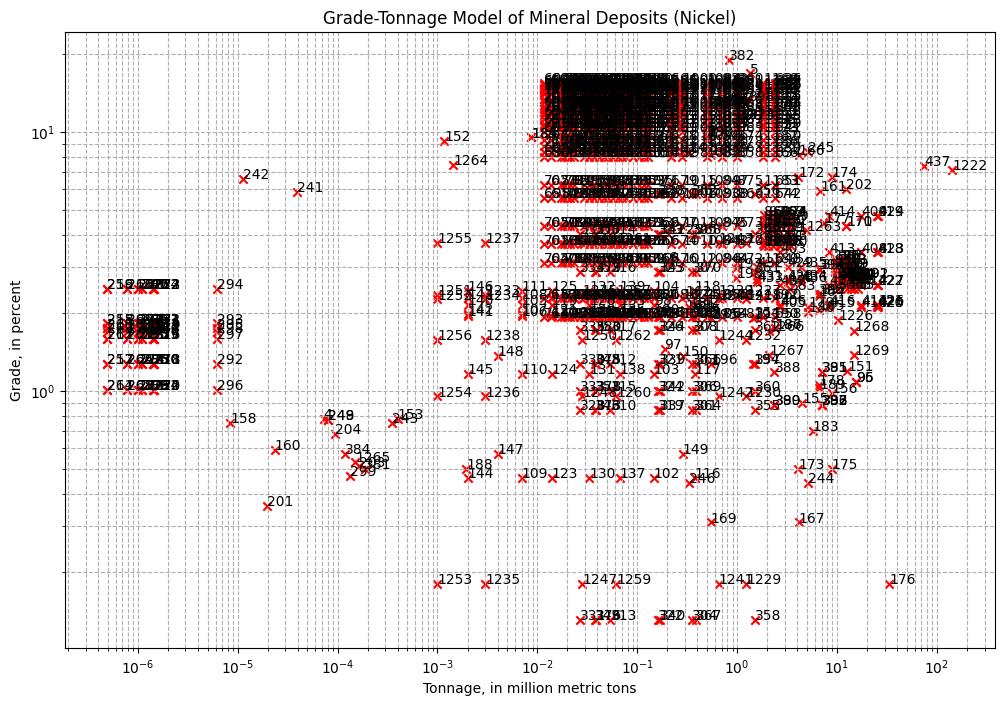

In [72]:
tonnages = mineral_data_df['tonnage'].values
grades = mineral_data_df['grade'].values
names = mineral_data_df.index.values # mineral_data_df['name'].values

# todo: convert tonnage to million metric tons using unit-transformation
tonnages_million_metric_tons = tonnages / 1e6

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tonnages_million_metric_tons, grades, marker='x', color='r')

# loga scale
plt.xscale('log')
plt.yscale('log')

# todo: units should be evaluated and converted
plt.xlabel('Tonnage, in million metric tons')
plt.ylabel('Grade, in percent')
plt.title('Grade-Tonnage Model of Mineral Deposits (Nickel)')

plt.grid(True, which="both", ls="--")
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages_million_metric_tons[i], grades[i]))
plt.show()

### 6. Coordinate data

In [73]:
from shapely import wkt
from shapely.wkt import loads
from shapely.errors import WKTReadingError

tqdm.pandas()

def safe_wkt_load(wkt_string):
    try:
        return loads(wkt_string)
    except WKTReadingError as e:
        print(f"Error converting WKT: {e}")
        return None

In [74]:
query = '''
SELECT ?site ?loc ?tonnage ?grade
WHERE {
  ?site a :MineralSite .
  ?site :mineral_inventory ?inv .

  ?inv :commodity [ :name "Nickel"@en ] .
  ?inv :category  :Indicated .
  ?inv :ore       [ :ore_value   ?tonnage ] .
  ?inv :grade     [ :grade_value ?grade ] .
  
  ?site:location_info [ :location ?loc ] .
  FILTER(datatype(?loc) = geo:wktLiteral)
}
'''
loc_df = run_minmod_query(query, values=True)
loc_df['loc_wkt'] = loc_df['loc.value'].progress_apply(safe_wkt_load)
loc_df.dropna(inplace=True)
loc_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 15036.34it/s]


,site.value,loc.value,tonnage.value,grade.value,loc_wkt
0,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.06776 46.49230),40.8,1.27,POINT (-81.06776 46.4923)
1,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.87806 46.80500),0.264,0.65,POINT (-80.87806 46.805)
2,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.38751 46.42380),9.741,0.63,POINT (-81.38751 46.4238)
3,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.13276 46.74104),1.56,0.94,POINT (-81.13276 46.74104)
4,https://minmod.isi.edu/resource/site__ramu__mu...,POINT (145.20393 -5.57077),42.0,0.9,POINT (145.20393 -5.57077)
5,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.79985 46.58103),23.25,2.1,POINT (-80.79985 46.58103)
6,https://minmod.isi.edu/resource/site__maturi-i...,POINT (-91.8 47.8),818.3,0.18,POINT (-91.8 47.8)
7,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.89786 46.56702),0.56,1.17,POINT (-80.89786 46.56702)
8,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.87570 46.77810),6.7,0.72,POINT (-80.8757 46.7781)
9,https://minmod.isi.edu/resource/site__stillwat...,POINT (-109.9 45.39),55.4,0.1,POINT (-109.9 45.39)


## Deposit Type Classification

In [55]:
query = '''
SELECT ?ms ?dt_conf ?dt_s ?dt_on ?cn ?cg ?ce ?country
WHERE {
  ?ms a :MineralSite .

  ?ms :location_info [ :country ?country ] .
  #?ms :location_info [ :location ?loc ] .
  #FILTER(datatype(?loc) = geo:wktLiteral)
  
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  ?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  
  OPTIONAL { ?dpc :normalized_uri [
      rdfs:label ?cn;
      :deposit_group ?cg;
      :environment ?ce ] }
}
'''
tmp_df = run_minmod_query(query, values=True)
tmp_df

,ms.value,dt_conf.value,dt_s.value,dt_on.value,cn.value,cg.value,ce.value,country.value
0,https://minmod.isi.edu/resource/mrds10183827,0.0327790342271328,"algorithm predictions, SRI deposit type classi...",Porphyry tungsten,Porphyry tungsten,Porphyry,Magmatic hydrothermal,Spain
1,https://minmod.isi.edu/resource/mrds10183827,0.029485883191227913,"algorithm predictions, SRI deposit type classi...",Vein tungsten,Vein tungsten,Vein,Magmatic hydrothermal,Spain
2,https://minmod.isi.edu/resource/mrds10183827,0.02389947883784771,"algorithm predictions, SRI deposit type classi...",Fluvial placer tungsten,Fluvial placer tungsten,Placer,Erosional,Spain
3,https://minmod.isi.edu/resource/mrds10183827,0.016497410833835602,"algorithm predictions, SRI deposit type classi...",Greisen tungsten- molybdenum±Bi,Greisen tungsten- molybdenum±Bi,Greisen,Magmatic hydrothermal,Spain
4,https://minmod.isi.edu/resource/mrds10183827,0.015555216930806637,"algorithm predictions, SRI deposit type classi...",Skarn tungsten ± Mo,Skarn tungsten ± Mo,Skarn,Magmatic hydrothermal,Spain
...,...,...,...,...,...,...,...,...
104588,https://minmod.isi.edu/resource/mrds10307429,0.026404917240142822,"algorithm predictions, SRI deposit type classi...",Non-sulfide zinc-lead ± Mn,Non-sulfide zinc-lead ± Mn,Non-sulfide,Basin hydrothermal,United States
104589,https://minmod.isi.edu/resource/mrds10307429,0.037319548428058624,"algorithm predictions, SRI deposit type classi...",Supergene lead,Supergene lead,Supergene,Supergene,United States
104590,https://minmod.isi.edu/resource/mrds10307429,0.02521389164030552,"algorithm predictions, SRI deposit type classi...",Siliciclastic-mafic zinc-lead,Siliciclastic-mafic zinc-lead,Sediment-hosted,Basin hydrothermal,United States
104591,https://minmod.isi.edu/resource/mrds10307429,0.024124963209033012,"algorithm predictions, SRI deposit type classi...",Siliciclastic- carbonate zinc-lead,Siliciclastic- carbonate zinc-lead,Sediment-hosted,Basin hydrothermal,United States


In [56]:
nickel_dc_data_df = pd.DataFrame([
    {
        'url': row['ms.value'], # navigable
        #'name': row['ms.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'confidence': row['dt_conf.value'],
        'source': row['dt_s.value'],
        'observed_deposit_name': row['dt_on.value'],
        'deposit_name': row['cn.value'],
        'deposit_group': row['cg.value'],
        'deposit_environment': row['ce.value'],
        'country': row['country.value']
    }
    for index, row in tmp_df.iterrows()
])
nickel_dc_data_df

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
0,https://minmod.isi.edu/resource/mrds10183827,0.0327790342271328,"algorithm predictions, SRI deposit type classi...",Porphyry tungsten,Porphyry tungsten,Porphyry,Magmatic hydrothermal,Spain
1,https://minmod.isi.edu/resource/mrds10183827,0.029485883191227913,"algorithm predictions, SRI deposit type classi...",Vein tungsten,Vein tungsten,Vein,Magmatic hydrothermal,Spain
2,https://minmod.isi.edu/resource/mrds10183827,0.02389947883784771,"algorithm predictions, SRI deposit type classi...",Fluvial placer tungsten,Fluvial placer tungsten,Placer,Erosional,Spain
3,https://minmod.isi.edu/resource/mrds10183827,0.016497410833835602,"algorithm predictions, SRI deposit type classi...",Greisen tungsten- molybdenum±Bi,Greisen tungsten- molybdenum±Bi,Greisen,Magmatic hydrothermal,Spain
4,https://minmod.isi.edu/resource/mrds10183827,0.015555216930806637,"algorithm predictions, SRI deposit type classi...",Skarn tungsten ± Mo,Skarn tungsten ± Mo,Skarn,Magmatic hydrothermal,Spain
...,...,...,...,...,...,...,...,...
104588,https://minmod.isi.edu/resource/mrds10307429,0.026404917240142822,"algorithm predictions, SRI deposit type classi...",Non-sulfide zinc-lead ± Mn,Non-sulfide zinc-lead ± Mn,Non-sulfide,Basin hydrothermal,United States
104589,https://minmod.isi.edu/resource/mrds10307429,0.037319548428058624,"algorithm predictions, SRI deposit type classi...",Supergene lead,Supergene lead,Supergene,Supergene,United States
104590,https://minmod.isi.edu/resource/mrds10307429,0.02521389164030552,"algorithm predictions, SRI deposit type classi...",Siliciclastic-mafic zinc-lead,Siliciclastic-mafic zinc-lead,Sediment-hosted,Basin hydrothermal,United States
104591,https://minmod.isi.edu/resource/mrds10307429,0.024124963209033012,"algorithm predictions, SRI deposit type classi...",Siliciclastic- carbonate zinc-lead,Siliciclastic- carbonate zinc-lead,Sediment-hosted,Basin hydrothermal,United States


In [57]:
nickel_dc_data_df['source'].value_counts()

source
algorithm predictions, SRI deposit type classification, v0b, 20240213    102900
sand                                                                       1686
SME                                                                           7
Name: count, dtype: int64

In [58]:
nickel_dc_data_df['country'].value_counts()

country
United States    71918
Canada            4966
Australia         3101
Bolivia           2825
Russia            2737
                 ...  
Cameroon             4
Côte d'Ivoire        4
Togo                 3
Oman                 3
Guinea               3
Name: count, Length: 118, dtype: int64

In [62]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United")]['country'].value_counts()

country
United States               71918
United Kingdom                 95
United States of America        6
Name: count, dtype: int64

In [63]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United States")]

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
10,https://minmod.isi.edu/resource/mrds10111819,0.016684068366885185,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion PGE,U-M layered intrusion PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
11,https://minmod.isi.edu/resource/mrds10111819,0.02597236260771751,"algorithm predictions, SRI deposit type classi...",Ophiolite chromium,Ophiolite chromium,Ophiolite,Magmatic,United States
12,https://minmod.isi.edu/resource/mrds10111819,0.016139039769768715,"algorithm predictions, SRI deposit type classi...",Fluvial placer PGE,Fluvial placer PGE,Placer,Erosional,United States
13,https://minmod.isi.edu/resource/mrds10111819,0.028219912201166153,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion chromium,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
14,https://minmod.isi.edu/resource/mrds10111819,0.02360784076154232,"algorithm predictions, SRI deposit type classi...",Mafic-ultramafic VMS,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal,United States
...,...,...,...,...,...,...,...,...
104588,https://minmod.isi.edu/resource/mrds10307429,0.026404917240142822,"algorithm predictions, SRI deposit type classi...",Non-sulfide zinc-lead ± Mn,Non-sulfide zinc-lead ± Mn,Non-sulfide,Basin hydrothermal,United States
104589,https://minmod.isi.edu/resource/mrds10307429,0.037319548428058624,"algorithm predictions, SRI deposit type classi...",Supergene lead,Supergene lead,Supergene,Supergene,United States
104590,https://minmod.isi.edu/resource/mrds10307429,0.02521389164030552,"algorithm predictions, SRI deposit type classi...",Siliciclastic-mafic zinc-lead,Siliciclastic-mafic zinc-lead,Sediment-hosted,Basin hydrothermal,United States
104591,https://minmod.isi.edu/resource/mrds10307429,0.024124963209033012,"algorithm predictions, SRI deposit type classi...",Siliciclastic- carbonate zinc-lead,Siliciclastic- carbonate zinc-lead,Sediment-hosted,Basin hydrothermal,United States


In [64]:
#nickel_dc_data_df.to_csv('nickel_dc_data_df.csv')